In [1]:
getwd()

[1] "/scratch/cloudstor/Modules Paper"

In [2]:
setwd("/Figure 4G")

In [3]:
sessionInfo()

R version 4.1.2 (2021-11-01)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: CentOS Linux 7 (Core)

Matrix products: default
BLAS:   /cvmfs/sft.cern.ch/lcg/releases/R/4.1.2-f9ee4/x86_64-centos7-gcc8-opt/lib64/R/lib/libRblas.so
LAPACK: /cvmfs/sft.cern.ch/lcg/releases/R/4.1.2-f9ee4/x86_64-centos7-gcc8-opt/lib64/R/lib/libRlapack.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

loaded via a namespace (and not attached):
 [1] fansi_1.0.3          crayon_1.5.1         utf8_1.2.2          
 [4] digest_0.6.29        IRdisplay_1.1.0.9000 repr_1.1.4.9000     
 [7] lifecycle_1.0.1 

In [4]:
list.files()

[1] "Age Enrichment GBM modules.r"               
 [2] "Age Enrichments GBM.txt"                    
 [3] "Fig 4G.pdf"                                 
 [4] "GBM Module ssGSEA Gini - CGGA.Rdata"        
 [5] "GBM.module.UC.MC.enrich.pvals.tsv"          
 [6] "Glioma Random Forest and plot Gini coeffs.r"
 [7] "modules_brain.Rdata"                        
 [8] "Phylostrata_PNAS.txt.txt"                   
 [9] "ssGSEA_of_GBM_modules_on_all.Rdata"         
[10] "Untitled.ipynb"

In [5]:
## Load required libraries
library(randomForest)
library(pROC)
library(dplyr)

randomForest 4.7-1.1

Type rfNews() to see new features/changes/bug fixes.

Type 'citation("pROC")' for a citation.


Attaching package: ‘pROC’


The following objects are masked from ‘package:stats’:

    cov, smooth, var



Attaching package: ‘dplyr’


The following object is masked from ‘package:randomForest’:

    combine


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




### Load and prepare ssGSEA scores for modelling:

In [6]:
load("ssGSEA_of_GBM_modules_on_all.Rdata")

In [7]:
LGG.mat.GBM.scores <- ssGSEA_of_GBM_modules_on_all[["LGG"]]
colnames( LGG.mat.GBM.scores ) <- paste("LGG", colnames(LGG.mat.GBM.scores) )

GBM.mat.GBM.scores <- ssGSEA_of_GBM_modules_on_all[["GBM"]]
colnames( GBM.mat.GBM.scores ) <- paste("GBM", colnames(GBM.mat.GBM.scores) )

combined.GBM.module.scores <- cbind(  LGG.mat.GBM.scores, GBM.mat.GBM.scores )

#### Divide samples by cohort of origin:

In [8]:
Type <- substr(colnames(combined.GBM.module.scores), 1,3)
combined.GBM.module.scores.for.RF <- data.frame( "Type"=Type, t(combined.GBM.module.scores) )

combined.GBM.module.scores.for.RF$Type <- as.factor(combined.GBM.module.scores.for.RF$Type)

#### Remove grey module:

In [9]:
combined.GBM.module.scores.for.RF <- combined.GBM.module.scores.for.RF[ , colnames(combined.GBM.module.scores.for.RF) !="grey"]

## This function runs iterations of RF model:

In [10]:
RF.Train.Test <- function( mod.scores, group1, group2, niter=100, rtest1=100, rtest2=100) {
  
  ### Function for performing 100 permutations of training and testing with a random forest
  ### on the specified data (mod.scores)
  ### niter = num of permutations to do
  ### rtest1 = num of samples to select for testing from group 1
  ### rtest2 = num of samples to select for testing from group 2
  
  auc.values <- vector(mode="numeric")
  accuracy <- vector(mode="numeric")
  ROCs <- list()
  Models <- list()
  
  ### Now have to divide into train and test sets
  for( j in 1:niter ) {
    rand.sample <- c( sample( group1, rtest1), sample( group2, rtest2) )
    #print(summary(rand.sample))
      
    Train <- mod.scores[ rand.sample, ]
    Valid <- mod.scores[ -rand.sample, ]
      
    #print( "Length of Train" )
    #print( dim(Train) )
    #print( paste( "Length of Valid", dim(Valid) ) )
          
    Train.RF <- randomForest(Type ~ ., data = Train, ntree = 500, mtry = 4, importance = TRUE, verbose=F)
    Models[[j]] <- Train.RF
    
    predict.probs <- predict( Train.RF, Valid, type = "prob", verbose=F )
    ### Assign predicted type
    predict <- predict( Train.RF, Valid, type = "Class", verbose=F )
    
    mod.auc <- roc(predict, apply(predict.probs,1,max), auc=1, verbose=F)
    ROCs[[j]] <- mod.auc
    
    auc.values[j] <- as.numeric( mod.auc$auc )
    
    accuracy[j] <- mean(  predict == Valid$Type)
  }
  
  return( list("AUC"=auc.values, "Accuracy"=accuracy, "ROC"=ROCs, "Models"=Models) )
}


### Train & test the model, dividing training/testing 70:30

In [11]:
RF.Mixed.permute.70.30 <- RF.Train.Test(mod.score=combined.GBM.module.scores.for.RF, group1=combined.GBM.module.scores.for.RF$Type=="LGG",
                                       group2=combined.GBM.module.scores.for.RF$Type=="GBM", rtest1=round( 512*0.3 ), rtest2=round( 153*0.3 ));

Setting levels: control = GBM, case = LGG

Setting direction: controls < cases

Setting levels: control = GBM, case = LGG

Setting direction: controls < cases

Setting levels: control = GBM, case = LGG

Setting direction: controls < cases

Setting levels: control = GBM, case = LGG

Setting direction: controls < cases

Setting levels: control = GBM, case = LGG

Setting direction: controls < cases

Setting levels: control = GBM, case = LGG

Setting direction: controls < cases

Setting levels: control = GBM, case = LGG

Setting direction: controls < cases

Setting levels: control = GBM, case = LGG

Setting direction: controls < cases

Setting levels: control = GBM, case = LGG

Setting direction: controls < cases

Setting levels: control = GBM, case = LGG

Setting direction: controls < cases

Setting levels: control = GBM, case = LGG

Setting direction: controls < cases

Setting levels: control = GBM, case = LGG

Setting direction: controls < cases

Setting levels: control = GBM, case = LG

In [12]:
combined.GBM.module.scores.for.RF$Type <- as.factor(combined.GBM.module.scores.for.RF$Type)

RF <- randomForest(Type ~ ., data = combined.GBM.module.scores.for.RF, ntree = 500, mtry = 4, importance = TRUE, verbose=F)


#### Collect the Gini coeffs for all modules

In [13]:
Gini.df.Mixed <- data.frame( lapply( RF.Mixed.permute.70.30[["Models"]], FUN=function(X){ as.numeric(X$importance[,4]) }) ) 
rownames(Gini.df.Mixed) <- rownames( RF.Mixed.permute.70.30[["Models"]][[1]]$importance )

### Get the percentage of MC genes in each GBM module

In [14]:
GBM.module.UC.MC.status <- read.table("GBM.module.UC.MC.enrich.pvals.tsv", sep="\t", head=T)

Age.Enrichments.GBM <- read.table("Age Enrichments GBM.txt", head=T, sep="\t")

In [15]:
getwd()

[1] "/Figure 4G"

#### Plot Gini Coefficients

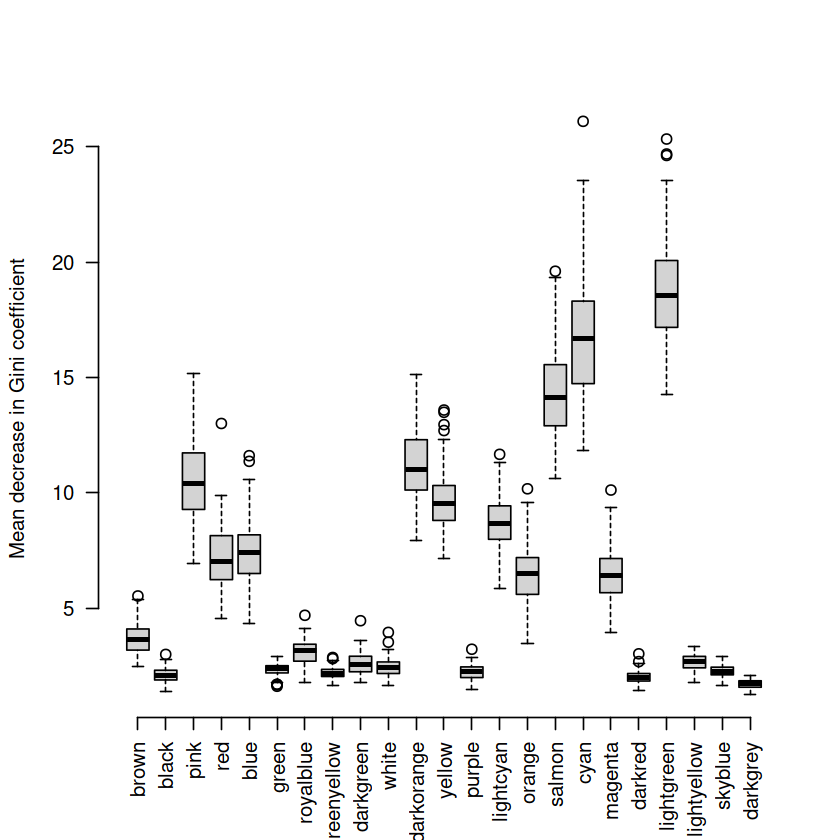

In [16]:
boxplot(t(Gini.df.Mixed), las=2, frame=F, ylab="Mean decrease in Gini coefficient")  ##, xlab="WGCNA Module"


### Plot Ginis ordered by percentage of MC genes in the module:

#### Read in data on prct MC genes per module:

##### load in required data on gene phylostrata assignments

In [17]:
### Data generated by ____ R script
Gene.Phylostrata <- read.csv("Phylostrata_PNAS.txt.txt")

### Data generated by ____ R script
#Age.Enrichments.GBM <- read.table("Age Enrichments GBM.txt", head=T, sep="\t")

load("modules_brain.Rdata")

In [18]:
summary(Gene.Phylostrata)

    GeneID              Entrez           Phylostrata    
 Length:17318       Min.   :        0   Min.   : 1.000  
 Class :character   1st Qu.:     6388   1st Qu.: 2.000  
 Mode  :character   Median :    27336   Median : 4.000  
                    Mean   :   734703   Mean   : 5.434  
                    3rd Qu.:    85463   3rd Qu.: 8.000  
                    Max.   :102466515   Max.   :16.000  

#### Figure out if each module is UC, MC or UC-MC mixed.

In [19]:
fisher.pvals <- list()

for( colour in names(modules_brain$GBM) ) {

    mod.genes <- modules_brain$GBM[[colour]]

    mod.phylo <- subset( Gene.Phylostrata, GeneID %in% mod.genes )

    MC.fraction = mean( mod.phylo$Phylostrata > 3 )

    MC.pval <- fisher.test(cbind(  
           as.numeric( summary( Gene.Phylostrata$Phylostrata > 3)[-1] ),
           as.numeric( summary( mod.phylo$Phylostrata > 3)[-1] )
      ), alt="g" )$p.val

    UC.pval <- fisher.test(cbind(  
           as.numeric( summary( mod.phylo$Phylostrata <=3 )[-1] ),
           as.numeric( summary( Gene.Phylostrata$Phylostrata <= 3)[-1] )
            ), alt="l" )$p.val

    fisher.pvals[["GBM"]][[colour]] <-  c( UC.pval, MC.pval, MC.fraction )
}

#### Determine age enrichment status for each module based on enrichment p-values for each gene category

In [20]:
GBM.module.UC.MC.status <- rbind( data.frame( fisher.pvals[["GBM"]]),
"Is UC"=as.vector( data.frame( fisher.pvals[["GBM"]] )[1,] <0.05 ),
"Is MC"=as.vector( data.frame( fisher.pvals[["GBM"]] )[2,] <0.05 )
)

rownames(GBM.module.UC.MC.status) <- c("UC enrich pval", "MC enrich pval", "prct MC", "Is UC", "Is MC")


In [21]:
GBM.module.UC.MC.status

,brown,black,pink,red,blue,green,royalblue,greenyellow,darkgreen,grey,⋯,lightcyan,orange,salmon,cyan,magenta,darkred,lightgreen,lightyellow,skyblue,darkgrey
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
UC enrich pval,0.8870344,2.053233e-16,0.004426228,0.4548710,1.058367e-125,4.554076e-21,0.99012892,0.6311240,0.9997315894,0.1130024,⋯,1.517546e-05,0.01517953,0.01767054,0.5973398,1.392468e-08,0.0000674157,1.548661e-05,0.99294324,0.6750255,3.707401e-11
MC enrich pval,0.1286023,1.000000e+00,0.996983636,0.5917612,1.000000e+00,1.000000e+00,0.01903247,0.4311708,0.0007022583,0.9536791,⋯,9.999938e-01,0.99289444,0.98896838,0.4497085,1.000000e+00,0.9999759545,9.999946e-01,0.01322356,0.4624533,1.000000e+00
prct MC,0.6335150,3.853211e-01,0.528000000,0.6072607,4.217374e-01,3.783784e-01,0.73611111,0.6219512,0.7945205479,0.4444444,⋯,4.019608e-01,0.44897959,0.51260504,0.6174497,4.212963e-01,0.3731343284,3.648649e-01,0.73255814,0.6363636,2.828283e-01
Is UC,0.0000000,1.000000e+00,1.000000000,0.0000000,1.000000e+00,1.000000e+00,0.00000000,0.0000000,0.0000000000,0.0000000,⋯,1.000000e+00,1.00000000,1.00000000,0.0000000,1.000000e+00,1.0000000000,1.000000e+00,0.00000000,0.0000000,1.000000e+00
Is MC,0.0000000,0.000000e+00,0.000000000,0.0000000,0.000000e+00,0.000000e+00,1.00000000,0.0000000,1.0000000000,0.0000000,⋯,0.000000e+00,0.00000000,0.00000000,0.0000000,0.000000e+00,0.0000000000,0.000000e+00,1.00000000,0.0000000,0.000000e+00


#### Plot the Gini coefficients ordered by percentage of MC genes

Warning message in xtfrm.data.frame(x):
“cannot xtfrm data frames”


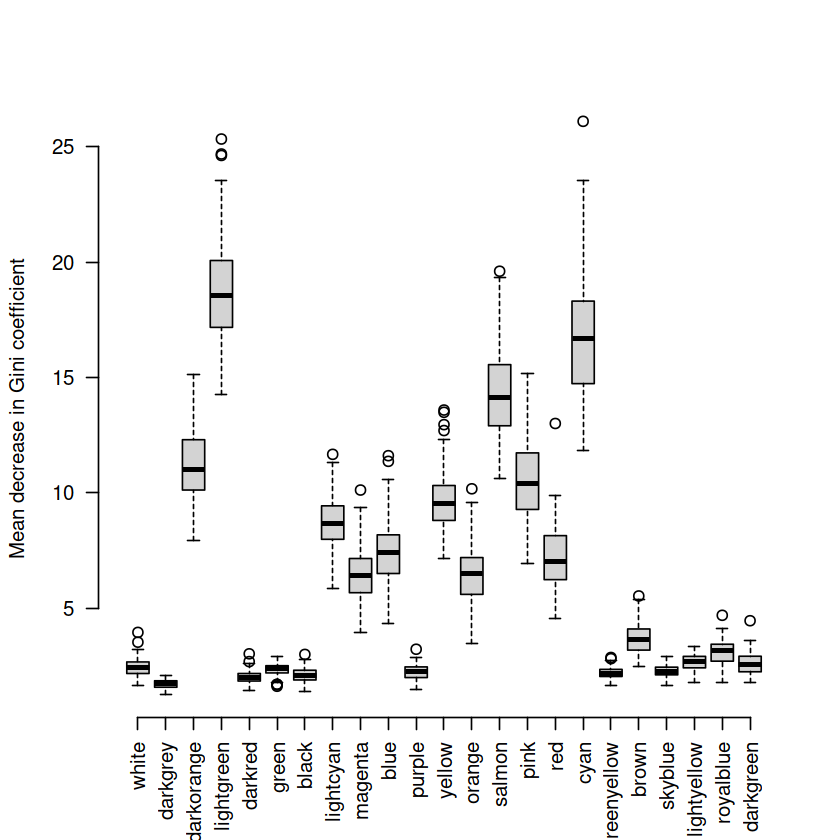

In [22]:
Gini.df.Mixed.ordered.by.prctMC <- t(Gini.df.Mixed)[,order(GBM.module.UC.MC.status[3,colnames(GBM.module.UC.MC.status) != "grey"])]

boxplot(Gini.df.Mixed.ordered.by.prctMC, las=2, frame=F, ylab="Mean decrease in Gini coefficient")  

#### Add age enrichment category to modules

In [23]:
#GBM.module.UC.MC.status[1,]

#Apply Bonferroni correction to UC and MC gene enrichment p-values
UC.padj <- vapply(GBM.module.UC.MC.status[1,], FUN= function(K) { min(1, K * ncol(GBM.module.UC.MC.status) ) }, 2)
MC.padj <-vapply(GBM.module.UC.MC.status[2,], FUN= function(K) { min(1, K * ncol(GBM.module.UC.MC.status) ) }, 2)

Age.Enrichments.GBM <- rbind( UC.padj , MC.padj )

Age.Enrichments.GBM

Age.Enrichments.GBM

,brown,black,pink,red,blue,green,royalblue,greenyellow,darkgreen,grey,⋯,lightcyan,orange,salmon,cyan,magenta,darkred,lightgreen,lightyellow,skyblue,darkgrey
UC.padj,1,4.92776e-15,0.1062295,1,2.540081e-124,1.092978e-19,1.0000000,1,1.0000000,1,⋯,0.0003642111,0.3643087,0.424093,1,3.341923e-07,0.001617977,0.0003716785,1.0000000,1,8.897763e-10
MC.padj,1,1.00000e+00,1.0000000,1,1.000000e+00,1.000000e+00,0.4567792,1,0.0168542,1,⋯,1.0000000000,1.0000000,1.000000,1,1.000000e+00,1.000000000,1.0000000000,0.3173655,1,1.000000e+00


,brown,black,pink,red,blue,green,royalblue,greenyellow,darkgreen,grey,⋯,lightcyan,orange,salmon,cyan,magenta,darkred,lightgreen,lightyellow,skyblue,darkgrey
UC.padj,1,4.92776e-15,0.1062295,1,2.540081e-124,1.092978e-19,1.0000000,1,1.0000000,1,⋯,0.0003642111,0.3643087,0.424093,1,3.341923e-07,0.001617977,0.0003716785,1.0000000,1,8.897763e-10
MC.padj,1,1.00000e+00,1.0000000,1,1.000000e+00,1.000000e+00,0.4567792,1,0.0168542,1,⋯,1.0000000000,1.0000000,1.000000,1,1.000000e+00,1.000000000,1.0000000000,0.3173655,1,1.000000e+00


### Next order the modules by age enrichment category, THEN prct MC genes

In [24]:
Age.Enrichments.GBM <- read.table("Age Enrichments GBM.txt", head=T, sep="\t")
Age.Enrichments.GBM

,tumour,tissue_type,cluster,p_UC_enrichment,p_MC_enrichment,p_UC_adj,p_MC_adj,Module_age
,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,GBM,tumour,brown,1.000000e+00,2.905017e-19,1.000000e+00,6.972041e-18,MC
2,GBM,tumour,black,3.267177e-03,9.977024e-01,1.960306e-02,9.999988e-01,UC
3,GBM,tumour,pink,9.821299e-01,2.432649e-02,1.000000e+00,7.297948e-02,Mixed
4,GBM,tumour,red,9.999997e-01,4.783060e-07,1.000000e+00,2.295869e-06,MC
5,GBM,tumour,blue,1.433115e-06,9.999988e-01,3.439475e-05,9.999988e-01,UC
6,GBM,tumour,green,4.613751e-04,9.996826e-01,3.691001e-03,9.999988e-01,UC
7,GBM,tumour,royalblue,9.999993e-01,2.516121e-06,1.000000e+00,1.006448e-05,MC
8,GBM,tumour,greenyellow,9.999821e-01,3.548685e-05,1.000000e+00,1.216692e-04,MC
9,GBM,tumour,darkgreen,1.000000e+00,7.433296e-09,1.000000e+00,8.919955e-08,MC


#### Order the Modules by assigned age category

In [25]:
Gini.df.Mixed.ordered.by.age.en <- Gini.df.Mixed.ordered.by.prctMC[ , colnames(Gini.df.Mixed.ordered.by.prctMC) %in% filter(Age.Enrichments.GBM, Module_age=="UC")$cluster ]

rownames(Gini.df.Mixed.ordered.by.age.en) <- c(1:100)

Gini.df.Mixed.ordered.by.age.en <- 
  cbind( Gini.df.Mixed.ordered.by.age.en, 
       Gini.df.Mixed.ordered.by.prctMC[ , colnames(Gini.df.Mixed.ordered.by.prctMC) %in% filter(Age.Enrichments.GBM, Module_age=="Mixed")$cluster ]
  )       

Gini.df.Mixed.ordered.by.age.en <- 
  cbind( Gini.df.Mixed.ordered.by.age.en, 
         Gini.df.Mixed.ordered.by.prctMC[ , colnames(Gini.df.Mixed.ordered.by.prctMC) %in% filter(Age.Enrichments.GBM, Module_age=="MC")$cluster ]
  )       

#### Now plot Ginis, coloured by age enrichment

In [37]:
pdf("Fig 4G.pdf", width=6, height=4)

par(mar=c(6, 4, 3, 2) + 0.1)
boxplot(Gini.df.Mixed.ordered.by.age.en, las=2, frame=F, ylab="Mean decrease in Gini coefficient", col=c(rep("tomato",5),rep("lightgreen",11), rep("skyblue",7)), ylim=c(0,30))
legend( 0, 30, fill=c('#F8766D', '#00BA38', '#619CFF' ), legend=c("UC-enriched", "Mixed UC-MC", "MC-enriched"), bty="n", horiz=T, cex=1.2 )

dev.off()

png 
  2